In [ ]:
import os

# Set the GPUs of the server
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"  # for 3B
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # for 1B

# Clean the environment
import gc
gc.collect()
torch.cuda.empty_cache()

Using device: cuda


In [ ]:
# Import necessary libraries
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig,LlamaTokenizer
from huggingface_hub import notebook_login
from datasets import load_dataset
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
from datetime import datetime


In [ ]:
# Login to Hugging Face
from huggingface_hub import login
login(token='hf_**********************************')


In [ ]:
base_model = "meta-llama/Llama-3.2-1B"
new_model = "newModel1B_QA"

torch_dtype = torch.float16
attn_implementation = "eager"

In [5]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    device_map="auto",
    attn_implementation=attn_implementation,
)


In [ ]:
# Load the test data
import json
with open('/srv/data1/fuxiaoqin/Downloads/EngineeringReference1_5_TESTQAGPT4omini.json', 'r', encoding='utf-8') as file:  
    json_obj = json.load(file)  

data_instructions = []
data_inputs = []
data_outputs = []
for piece in json_obj:
    # print("piece", piece['input'])
    # data_chunkis.append(piece['chunki'])
    data_instructions.append(piece['instruction'])
    data_inputs.append(piece['input'])
    data_outputs.append(piece['output'])



In [7]:
print(len(data_instructions))
print(len(data_inputs))
print(len(data_outputs))
# print(data_instructions)

17
17
17


In [ ]:
# Disable WandB
#!{sys.executable} -m pip uninstall -q wandb
import os
os.environ["WANDB_DISABLED"] = "true"

In [9]:
from trl import SFTTrainer, setup_chat_format
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)
model, tokenizer = setup_chat_format(model, tokenizer)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [ ]:
# Get the answers from the model and tokenizer according to the question inputs
def get_responses(data_inputs, model, tokenizer):
    responses = []
    for dp in data_inputs:
    # for i in range(21,27):
        # dp = data_inputs[i]
        messages = [
            {
                "role": "user",
                # "content": "What is the climate of a building located in west Arizona? (In a sentence)"
                "content": dp + " (In a sentence)"
            }
        ]
        
        prompt = tokenizer.apply_chat_template(messages, tokenize=False,
                                               add_generation_prompt=True)
        
        inputs = tokenizer(prompt, return_tensors='pt', padding=True,
                           truncation=True).to("cuda")
        
        outputs = model.generate(**inputs, max_length=150,
                                 num_return_sequences=1)
        
        text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        #  print(text)
        # print(text.split("assistant"))
        # print(dp +" "+text.split("assistant")[1])
        response = text.split("assistant")[1].replace("\n","").split(", ")[0].split(". ")[0].strip()+"."
        responses.append(response)
    return responses


In [ ]:
# Get the answers from the tokenizer and model base according to the question inputs
pretrained_responses = get_responses(data_inputs, model, tokenizer)
# print("pretrained_responses =", pretrained_responses)
print("len(pretrained_responses) =", len(pretrained_responses))

len(pretrained_responses) = 17


In [12]:
def save_results_csv(fileName, instructions, inputs, outputs, predictions):
    min_len = 17 # min (len(instructions), len(inputs), len(outputs), len(predictions))
    wf = open(fileName, 'w', encoding="utf8")
    wf.write("Instruction,Input,Output,Predicted\n")
    for i in range(min_len):
        wf.write(str(instructions[i])+','+str(inputs[i])+',"'+str(outputs[i])+'","'+str(predictions[i])+'"\n')
    wf.close()


In [ ]:
references = data_outputs
print("len(references)", len(references))
# print("len(pretrained_responses)", len(pretrained_responses))

# Import the libraries related to the evaluation metrics
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from numpy import *
from rouge import Rouge
from bert_score import score

def compute_bleu(reference, hypothesis):
    reference = [reference.split()]
    hypothesis = hypothesis.split()
    smoothie = SmoothingFunction().method4
    return sentence_bleu(reference, hypothesis, smoothing_function=smoothie)

def save_metrics_csv(fileName, modelName, bleus, rouge1, rouge2, rouge3, b_r, b_p, b_f):
    bleu = mean(bleus)
    r1_r=rouge1['r']
    r1_p=rouge1['p']
    r1_f=rouge1['f']
    r2_r=rouge2['r']
    r2_p=rouge2['p']
    r2_f=rouge2['f']
    r3_r=rouge3['r']
    r3_p=rouge3['p']
    r3_f=rouge3['f']    
    b_r = str(b_r).replace("tensor(","").replace(")","")
    b_p = str(b_p).replace("tensor(","").replace(")","")
    b_f = str(b_f).replace("tensor(","").replace(")","")
    # if os.path.exists(fileName):
    #     r = open(fileName, 'a', encoding="utf8")
    #     r.write(str(modelName)+","+str(bleu)+","+str(r1_r)+","+str(r1_p)+","+str(r1_f)+","+str(r2_r)+","+str(r2_p)+","+str(r2_f)+","+str(r3_r)+","+str(r3_p)+","+str(r3_f)+","+str(b_r)+","+str(b_p)+","+str(b_f)+",\n")
    #     r.close()
    # else:
    r = open(fileName, 'w', encoding="utf8")
    r.write("Training,BLEU,ROUGE-1,,,ROUGE-2,,,ROUGE-L,,,BERT,,,Fineturning\n")
    r.write("/Testing,,r ,p,f,r ,p,f,r ,p,f,R,P,F1,Time\n")
    r.write(str(modelName)+","+str(bleu)+","+str(r1_r)+","+str(r1_p)+","+str(r1_f)+","+str(r2_r)+","+str(r2_p)+","+str(r2_f)+","+str(r3_r)+","+str(r3_p)+","+str(r3_f)+","+str(b_r)+","+str(b_p)+","+str(b_f)+",\n")
    r.close()  
        
def compute_save_metrics(references, responses, fileName, modelName):
    # BLEU scores
    bleu_scores = [compute_bleu(ref, hypo) for ref, hypo in zip(references, responses)]
    print("BLEU scores with fineturning:", mean(bleu_scores))
    
    # ROUGE scores
    from rouge import Rouge
    rouge = Rouge()
    rouge1_r=0
    rouge1_p=0
    rouge1_f=0
    rouge2_r=0
    rouge2_p=0
    rouge2_f=0
    rougel_r=0
    rougel_p=0
    rougel_f=0
    rouge1 = {'r':0, 'p':0, 'f':0}
    rouge2 = {'r':0, 'p':0, 'f':0}
    rougel = {'r':0, 'p':0, 'f':0}
    try:
        rouge_scoress = rouge.get_scores(responses, references)
        for rouge_scores in rouge_scoress:
            rouge1=rouge_scores['rouge-1']
            rouge1_r += rouge1['r']
            rouge1_p += rouge1['p']
            rouge1_f += rouge1['f']
            rouge2=rouge_scores['rouge-2']   
            rouge2_r += rouge2['r']
            rouge2_p += rouge2['p']
            rouge2_f += rouge2['f']
            rougel=rouge_scores['rouge-l']       
            rougel_r += rougel['r']
            rougel_p += rougel['p']
            rougel_f += rougel['f']
        lenRouge = len(rouge_scoress)
        rouge1_r /= lenRouge
        rouge1_p /= lenRouge
        rouge1_f /= lenRouge
        rouge2_r /= lenRouge
        rouge2_p /= lenRouge
        rouge2_f /= lenRouge
        rougel_r /= lenRouge
        rougel_p /= lenRouge
        rougel_f /= lenRouge        
    except:
        print("No rouge scores")
    # ROUGE-1 Scores
    print(f"ROUGE-1 scores r, p, f with fine-turning: {rouge1_r}, {rouge1_p}, {rouge1_f} \n")    
    # ROUGE-2 scores
    print(f"ROUGE-2 scores r, p, f withfine-turning: {rouge2_r}, {rouge2_p}, {rouge2_f} \n")    
    # ROUGE-L scores
    print(f"ROUGE-l scores r, p, f with fine-turning: {rougel_r}, {rougel_p}, {rougel_f} \n")
    # ROUGE-W scores    
    
    #  BERTScore
    from bert_score import score
    # Calculate BERTScore
    P, R, F1 = score(responses, references, lang="en", rescale_with_baseline=True, verbose=True)
    print(f"type(P): {type(P)}\n")
    P = torch.mean(P)
    R = torch.mean(R)
    F1 = torch.mean(F1)
    # Print Rbert, Pbert and Fbert
    
    print(f"BERTScore-Precision with fineturning: {P}\n")
    print(f"\nBERTScore-Recall with fineturning: {R}\n")
    print(f"BERTScore-F-Measure with fineturning: {F1}")

    save_metrics_csv(fileName, modelName, bleu_scores, rouge1, rouge2, rougel, P, R, F1)

len(references) 17


In [ ]:
# Save the results and metrics of the Llama 3.2 1B model base to CSV files
save_results_csv("/srv/data1/fuxiaoqin/Results_LM32_1B_Before.csv", data_instructions, data_inputs, data_outputs, pretrained_responses)
compute_save_metrics(references, pretrained_responses, "/srv/data1/fuxiaoqin/Metrics_LM32_1B_Before.csv","LM32_1B")

BLEU scores with fineturning: 0.02642949183309564
ROUGE-1 scores r, p, f with fine-turning: 0.2353448185801127, 0.2694106882022087, 0.23452076157029902 

ROUGE-2 scores r, p, f withfine-turning: 0.1012401681546018, 0.10071652054349549, 0.0919480797329281 

ROUGE-l scores r, p, f with fine-turning: 0.20612937171760706, 0.23321186642154548, 0.2034252508197684 



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 106.74 sentences/sec
type(P): <class 'torch.Tensor'>

BERTScore-Precision with fineturning: -0.1774972677230835


BERTScore-Recall with fineturning: 0.04956745728850365

BERTScore-F-Measure with fineturning: -0.07127402722835541


In [ ]:
# Prepare the training data
from datasets import load_dataset
data_dict = {
    "train": os.path.join("/srv/data1/fuxiaoqin/Downloads/", "EngineeringReference1_5_QAGPT4.json")
   
}            
dataset = load_dataset("json", data_files=data_dict, split = "train")

def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"+tokenizer.eos_token
    return text
    
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))
dataset = dataset.map(generate_and_tokenize_prompt)
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"+tokenizer.eos_token
    return text
    
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))
dataset = dataset.map(generate_and_tokenize_prompt)

max_length = 512 # This was an appropriate max length for my dataset


def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result
    
dataset = dataset.map(generate_and_tokenize_prompt2)
print(dataset)

Dataset({
    features: ['instruction', 'input', 'output', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 193
})


In [ ]:
# Prepare the model for fine-tuning
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
import sys
# !{sys.executable} -m pip install peft wandb
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
)

# LoRA config
peft_config = LoraConfig(
    r=16, 
    lora_alpha=32, 
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)
model = get_peft_model(model, peft_config)
training_arguments = TrainingArguments(
    # output_dir="xfu20/Building_energy_Llama_1B_LoRA",
    output_dir="/srv/data1/fuxiaoqin/"+new_model+"/LoRA",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    # optim="paged_adamw_32bit",
    num_train_epochs=1,
    # eval_strategy="steps",
    # eval_steps=0.2,
    logging_steps=1,
    logging_dir="/srv/data1/fuxiaoqin/"+new_model+"/LoRALogs",
    warmup_steps=10,
    logging_strategy="steps",
    learning_rate=2e-4,
    fp16=True,  #False,
    bf16=False, #True,
    group_by_length=True,
    push_to_hub=True,
    # report_to="wandb"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Set the trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments,
)

/tmp/ipykernel_2096222/2529246835.py:1: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


In [ ]:
# Memory statistics before fine-tuning Llama 3.2 1B model with LoRA  
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024,3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
# print(f"Peak reserved memory = {used_memory} GB.")
print(f"LoRA peak reserved memory for the response without fine-tuning = {used_memory_for_lora} GB.")
# print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"LoRA peak reserved memory for the response without fine-tuning % of max memory = {lora_percentage} %.")

GPU = NVIDIA H100 PCIe. Max memory = 79.216 GB.
6.744 GB of memory reserved.
LoRA peak reserved memory for the response without fine-tuning = 0.0 GB.
LoRA peak reserved memory for the response without fine-tuning % of max memory = 0.0 %.


In [ ]:
# Fine-tuning Llama 3.2 1B model with LoRA and timeing
import time
start_time = time.time()

LoRA_result = trainer.train()

end_time = time.time()
lora_time = end_time - start_time
print("LoRA fine-tuning: {:.2f}seconds".format(lora_time))


Step,Training Loss
1,3.141900
2,3.988000
3,3.979800
4,3.912900
5,3.105400
6,3.603500
7,3.602600
8,3.381300
9,3.341700
10,2.316000


/srv/data1/fuxiaoqin/conda_envs/py2/lib/python3.12/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


LoRA fine-tuning: 127.04seconds


In [ ]:
# Memory statistics after fine-tuning Llama 3.2 1B model with LoRA  
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024,3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")


used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
# print(f"Peak reserved memory = {used_memory} GB.")
print(f"LoRA reserved memory for the response after fine-tuning = {used_memory_for_lora} GB.")
# print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"LoRA reserved memory for the response after fine-tuning % of max memory = {lora_percentage} %.")

model.config.use_cache = False

GPU = NVIDIA H100 PCIe. Max memory = 79.216 GB.
11.117 GB of memory reserved.
LoRA reserved memory for the response after fine-tuning = 0.0 GB.
LoRA reserved memory for the response after fine-tuning % of max memory = 0.0 %.


In [ ]:
# Upload the tokenizer and model of Llama 3.2 1B, which was fine-tuned with LoRA, to Hugging Face

tokenizer.push_to_hub("Building_energy_Llama_1B_LoRA")
model.push_to_hub("Building_energy_Llama_1B_LoRA")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

/srv/data1/fuxiaoqin/conda_envs/py2/lib/python3.12/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/xfu20/Building_energy_Llama_1B_LoRA/commit/8d26206afc8684eb2836599869b8d7a1ff190a71', commit_message='Upload model', commit_description='', oid='8d26206afc8684eb2836599869b8d7a1ff190a71', pr_url=None, repo_url=RepoUrl('https://huggingface.co/xfu20/Building_energy_Llama_1B_LoRA', endpoint='https://huggingface.co', repo_type='model', repo_id='xfu20/Building_energy_Llama_1B_LoRA'), pr_revision=None, pr_num=None)

In [ ]:
import matplotlib.pyplot as plt

# Plot the training loss
def finetuning_results(train_result, plot_title):
    metrics = train_result.metrics
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)

    # Initialize lists to store loss values and corresponding steps
    losses = []
    steps = []
    
    # Iterate through the log history
    for log in trainer.state.log_history:
        # Check if 'loss' is in the log entry
        if 'loss' in log:
            losses.append(log['loss'])
            # Use 'step' if available; otherwise, use 'epoch'
            steps.append(log.get('step', log.get('epoch')))
            
    # Create a plot of loss vs. steps
    plt.figure(figsize=(8, 5))
    plt.plot(steps, losses, marker='o', linestyle='-', color='blue')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(plot_title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return losses, steps

***** train metrics *****
  epoch                    =     0.9948
  total_flos               =   540757GF
  train_loss               =     2.4433
  train_runtime            = 0:00:31.04
  train_samples_per_second =      6.216
  train_steps_per_second   =      3.092


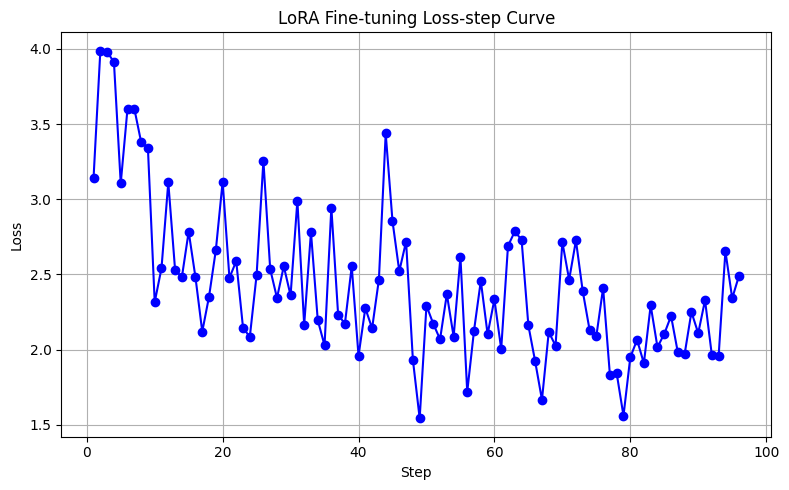

In [ ]:
# Plot the training loss of the Llama 3.2 1B model fine-tuned with LoRA
lora_losses, lora_steps = finetuning_results(LoRA_result, "LoRA Fine-tuning Loss-step Curve")

In [ ]:
# Get the answers from the tokenizer and the Llama 3.2 1B model fine-tuned with LoRA according to the question inputs

responses = get_responses(data_inputs, model, tokenizer)
print("len(responses) =", len(responses))

len(responses) = 17


In [ ]:
# Save the results and metrics of the Llama 3.2 1B model fine-tuned with LoRA to CSV files

save_results_csv("/srv/data1/fuxiaoqin/Results_LM32_1B_QA_LoRA.csv", data_instructions, data_inputs, data_outputs, responses)
compute_save_metrics(references, responses, "/srv/data1/fuxiaoqin/Metrics_LM32_1B_QA_LoRA.csv","LM32_1B")

BLEU scores with fineturning: 0.021723038040041505
ROUGE-1 scores r, p, f with fine-turning: 0.2196879808644514, 0.25454423883790517, 0.22127393751544272 

ROUGE-2 scores r, p, f withfine-turning: 0.08656956399096356, 0.09388075616625156, 0.08238129939769824 

ROUGE-l scores r, p, f with fine-turning: 0.2043285037402684, 0.2327990190108439, 0.20372437558327688 



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 143.77 sentences/sec
type(P): <class 'torch.Tensor'>

BERTScore-Precision with fineturning: -0.19256889820098877


BERTScore-Recall with fineturning: 0.011376110836863518

BERTScore-F-Measure with fineturning: -0.09400477260351181


In [ ]:
# QLoRA config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=True,
)

# Load the model again
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config = bnb_config, # Load QLoRA config
    device_map="auto",
    attn_implementation=attn_implementation,
)

from trl import SFTTrainer, setup_chat_format

# Load tokenizer again
tokenizer = AutoTokenizer.from_pretrained(base_model)
model, tokenizer = setup_chat_format(model, tokenizer)

# peft_config = LoraConfig(
#     r=16,  # 1,  #16
#     lora_alpha=32, # 1, #32,
#     lora_dropout=0.05,
#     bias="none",
#     task_type="CAUSAL_LM",
#     target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
# )

# Prepare the model for fine-tuning again

model = get_peft_model(model, peft_config)

training_arguments = TrainingArguments(
    output_dir="xfu20/Building_energy_Llama_1B_QLoRA",
    # output_dir="/srv/data1/fuxiaoqin/"+new_model+"/QLoRA",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    # optim="paged_adamw_32bit",
    num_train_epochs=1,
    # eval_strategy="steps",
    # eval_steps=0.2,
    logging_steps=1,
    # logging_dir="/srv/data1/fuxiaoqin/"+new_model+"/QLoRALogs",
    warmup_steps=10,
    logging_strategy="steps",
    learning_rate=2e-4,
    fp16=True,  #False,
    bf16=False, #True,
    group_by_length=True,
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [27]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    # eval_dataset=dataset["test"],
    peft_config=peft_config,
    # max_seq_length=512,
    # dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    # packing= False,
)

/tmp/ipykernel_2096222/2049995551.py:1: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


In [ ]:
# Memory statistics before fine-tuning Llama 3.2 1B model with QLoRA

gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory_qlora = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024,3)
max_memory_qlora = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory_qlora} GB.")
print(f"{start_gpu_memory_qlora} GB of memory reserved.")

used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_qlora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
qlora_percentage = round(used_memory_for_lora/max_memory*100, 3)
# print(f"Peak reserved memory = {used_memory} GB.")
print(f"QLoRA peak reserved memory for the response without fine-tuning = {used_memory_for_qlora} GB.")
# print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"QLoRA peak reserved memory for the response without fine-tuning % of max memory = {qlora_percentage} %.")

GPU = NVIDIA H100 PCIe. Max memory = 79.216 GB.
11.117 GB of memory reserved.
QLoRA peak reserved memory for the response without fine-tuning = 0.0 GB.
QLoRA peak reserved memory for the response without fine-tuning % of max memory = 0.0 %.


In [ ]:
# Fine-tuning Llama 3.2 1B model with QLoRA and timeing

start_time = time.time()

QLoRA_result = trainer.train()

end_time = time.time()
qlora_time = end_time - start_time
print("QLoRA fine-tuning: {:.2f}seconds".format(qlora_time))

Step,Training Loss
1,3.195300
2,4.079000
3,4.068800
4,4.036100
5,3.355400
6,3.821500
7,3.701900
8,3.518300
9,3.483600
10,2.445300


/srv/data1/fuxiaoqin/conda_envs/py2/lib/python3.12/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


QLoRA fine-tuning: 32.12seconds


In [ ]:
# Memory statistics after fine-tuning Llama 3.2 1B model with QLoRA  
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory_qlora = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024,3)
max_memory_qlora = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory_qlora} GB.")
print(f"{start_gpu_memory_qlora} GB of memory reserved.")

used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_qlora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
qlora_percentage = round(used_memory_for_lora/max_memory*100, 3)
# print(f"Peak reserved memory = {used_memory} GB.")
print(f"QLoRA reserved memory for the response after fine-tuning = {used_memory_for_qlora} GB.")
# print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"QLoRA reserved memory for the response after fine-tuning % of max memory = {qlora_percentage} %.")

GPU = NVIDIA H100 PCIe. Max memory = 79.216 GB.
11.117 GB of memory reserved.
QLoRA reserved memory for the response after fine-tuning = 0.0 GB.
QLoRA reserved memory for the response after fine-tuning % of max memory = 0.0 %.


In [ ]:
# Upload the tokenizer and model, which was fine-tuned with QLoRA, to Hugging Face
tokenizer.push_to_hub("Building_energy_Llama_1B_QLoRA")
model.push_to_hub("Building_energy_Llama_1B_QLoRA")

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

/srv/data1/fuxiaoqin/conda_envs/py2/lib/python3.12/site-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/xfu20/Building_energy_Llama_1B_QLoRA/commit/46757499d7f4e2a0b6f4ff530e3969490e496da2', commit_message='Upload model', commit_description='', oid='46757499d7f4e2a0b6f4ff530e3969490e496da2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/xfu20/Building_energy_Llama_1B_QLoRA', endpoint='https://huggingface.co', repo_type='model', repo_id='xfu20/Building_energy_Llama_1B_QLoRA'), pr_revision=None, pr_num=None)

***** train metrics *****
  epoch                    =     0.9948
  total_flos               =   540757GF
  train_loss               =     2.5171
  train_runtime            = 0:00:31.66
  train_samples_per_second =      6.095
  train_steps_per_second   =      3.032


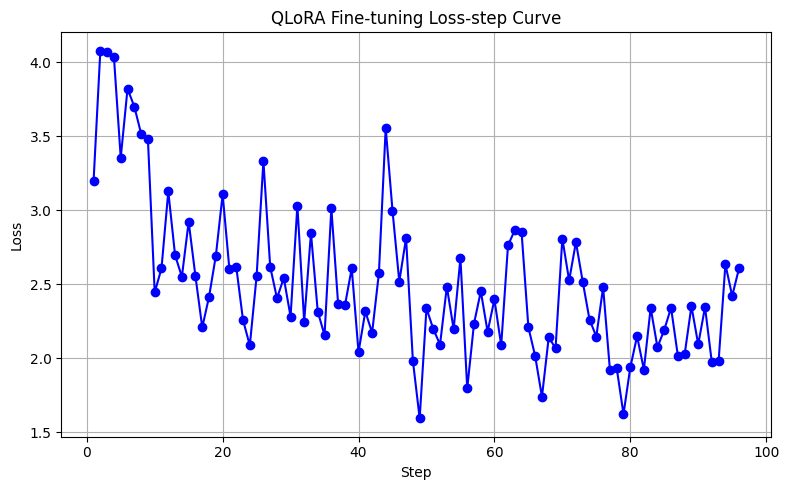

In [ ]:
# Plot the training loss of the Llama 3.2 1B model fine-tuned with QLoRA
qlora_losses, qlora_steps = finetuning_results(QLoRA_result, "QLoRA Fine-tuning Loss-step Curve")

In [ ]:
import numpy as np


# Plot and compare the training loss curves of two models
def two_loss_curves(losses1, steps1, losses2, steps2, plot_title):

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(steps1, losses1, label='LoRA', color='red', marker='o')
    plt.plot(steps2, losses2, label='QLoRA', color='green', marker='x')   
    plt.xlabel('Fine-tuning Step')
    plt.ylabel('Loss')
    plt.title(plot_title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save the figure
    # plt.savefig("loss_comparison_plot.png", dpi=300)
    plt.show()

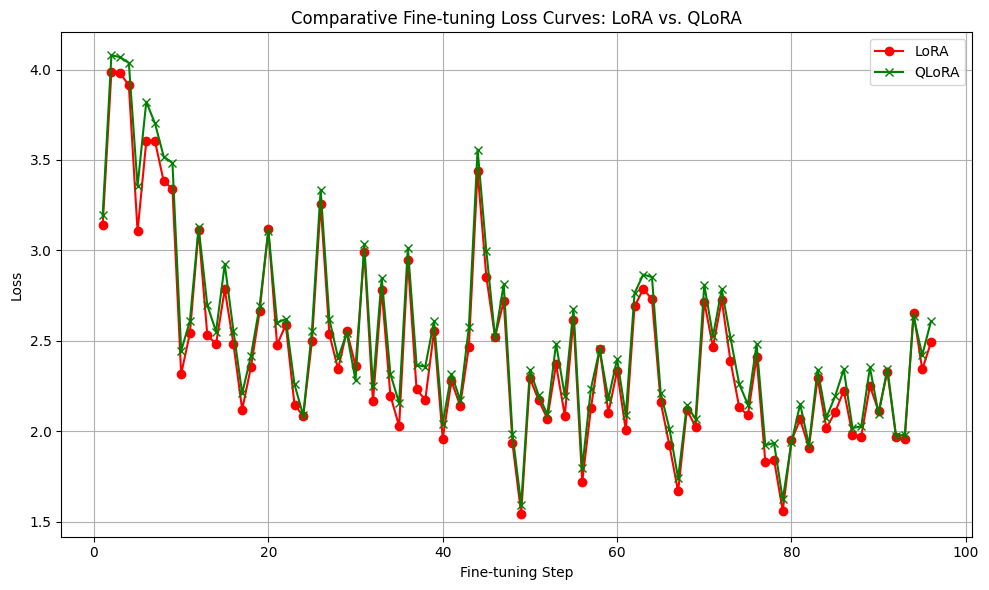

In [ ]:
# Plot and compare the training loss curves of Llama 3.2 1B models fine-tuned with LoRA and QLoRA
two_loss_curves(lora_losses, lora_steps, qlora_losses, qlora_steps, "Comparative Fine-tuning Loss Curves: LoRA vs. QLoRA")

In [ ]:
# Get the answers from the tokenizer and the Llama 3.2 1B model fine-tuned with QLoRA according to the question inputs

responses = get_responses(data_inputs, model, tokenizer)
print("len(responses) =", len(responses))

len(responses) = 17


In [ ]:
# Save the results and metrics of the Llama 3.2 1B model fine-tuned with QLoRA to CSV files

save_results_csv("/srv/data1/fuxiaoqin/Results_LM32_1B_QA_QLoRA.csv", data_instructions, data_inputs, data_outputs, responses)
compute_save_metrics(references, responses, "/srv/data1/fuxiaoqin/Metrics_LM32_1B_QA_QLoRA.csv","LM32_1B_QLoRA")

BLEU scores with fineturning: 0.018822408180583727
ROUGE-1 scores r, p, f with fine-turning: 0.21165810224633752, 0.24403384389543556, 0.2076757565786115 

ROUGE-2 scores r, p, f withfine-turning: 0.08092183481382263, 0.08517924264672035, 0.07275549534437709 

ROUGE-l scores r, p, f with fine-turning: 0.2000023288258582, 0.22872194990707098, 0.19527465578741787 



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 145.13 sentences/sec
type(P): <class 'torch.Tensor'>

BERTScore-Precision with fineturning: -0.19142071902751923


BERTScore-Recall with fineturning: 0.00493079237639904

BERTScore-F-Measure with fineturning: -0.09543934464454651


In [ ]:
#  Comparing the evaluation metrics of two models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def dataFromCSV(file_name):
    df = pd.read_csv(file_name)
    data = df.iloc[1].to_frame()
    # Clean data
    data = data.replace('Not Available', 0)
    data.fillna(0)
    data = data.replace(np.nan, 0, regex=True)
    index = ['Model', 'BLEU', 'ROUGE_1_r', 'ROUGE_1_p', 'ROUGE_1_f', 'ROUGE_2_r', 'ROUGE_2_p', 'ROUGE_2_f', 'ROUGE_L_r', 'ROUGE_L_p', 'ROUGE_L_f', 'BERT_R', 'BERT_P', 'BERT_F1', 'Fine-Tuning_Time']
    data.index = index
    data = data.drop(index=["Model", "Fine-Tuning_Time"])
    # print(f"data = {data}")
    return data

def compare2CSV(file1, file2):
    metrics1 =  dataFromCSV(file1)
    metrics2 =  dataFromCSV(file2)
    # metrics12  =  metrics1.join(metrics2, lsuffix='LoRA', rsuffix='QLoRA')
    metrics1.columns = ['LoRA']
    metrics2.columns = ['QLoRA']
    metrics12 = metrics1.join(metrics2)
    metrics12 = metrics12.reset_index()
    metrics12 = metrics12.rename(columns={"index": "Metric"})

    metrics12['LoRA'] = pd.to_numeric(metrics12['LoRA'], errors='coerce')
    metrics12['QLoRA'] = pd.to_numeric(metrics12['QLoRA'], errors='coerce')
    # print(f"metrics12 = {metrics12}")

    plt.figure(figsize=(20, 8))

    # Set the positions of the bars on the x-axis
    x_range = range(len(metrics12))

    bar_width = 0.35  # Bar width to allow space between the two bars
    bar_width = 0.35  # Bar width to allow space between the two bars
    bars_lora = plt.bar([i - bar_width / 2 for i in x_range], metrics12['LoRA'], width=bar_width, label='LoRA', color='blue', alpha=0.7)
    bars_qlora = plt.bar([i + bar_width / 2 for i in x_range], metrics12['QLoRA'], width=bar_width, label='QLoRA', color='orange', alpha=0.7)

    # Add value labels on each bar
    for bar in bars_lora:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), ha='center', va='bottom')

    for bar in bars_qlora:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), ha='center', va='bottom')

    # Add labels and title
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.title('Comparison of LoRA and QLoRA Fine-Tuning Llama 3.2 1B', fontsize=12)

    # Set the x-tick labels to the metric names, rotating them for readability
    plt.xticks(x_range, metrics12['Metric'], rotation=45)

    # Add a legend to distinguish between LoRA and QLoRA bars
    plt.legend()

    # Display the plot with a tight layout to avoid clipping
    plt.tight_layout()

    # Show the plot
    plt.show()

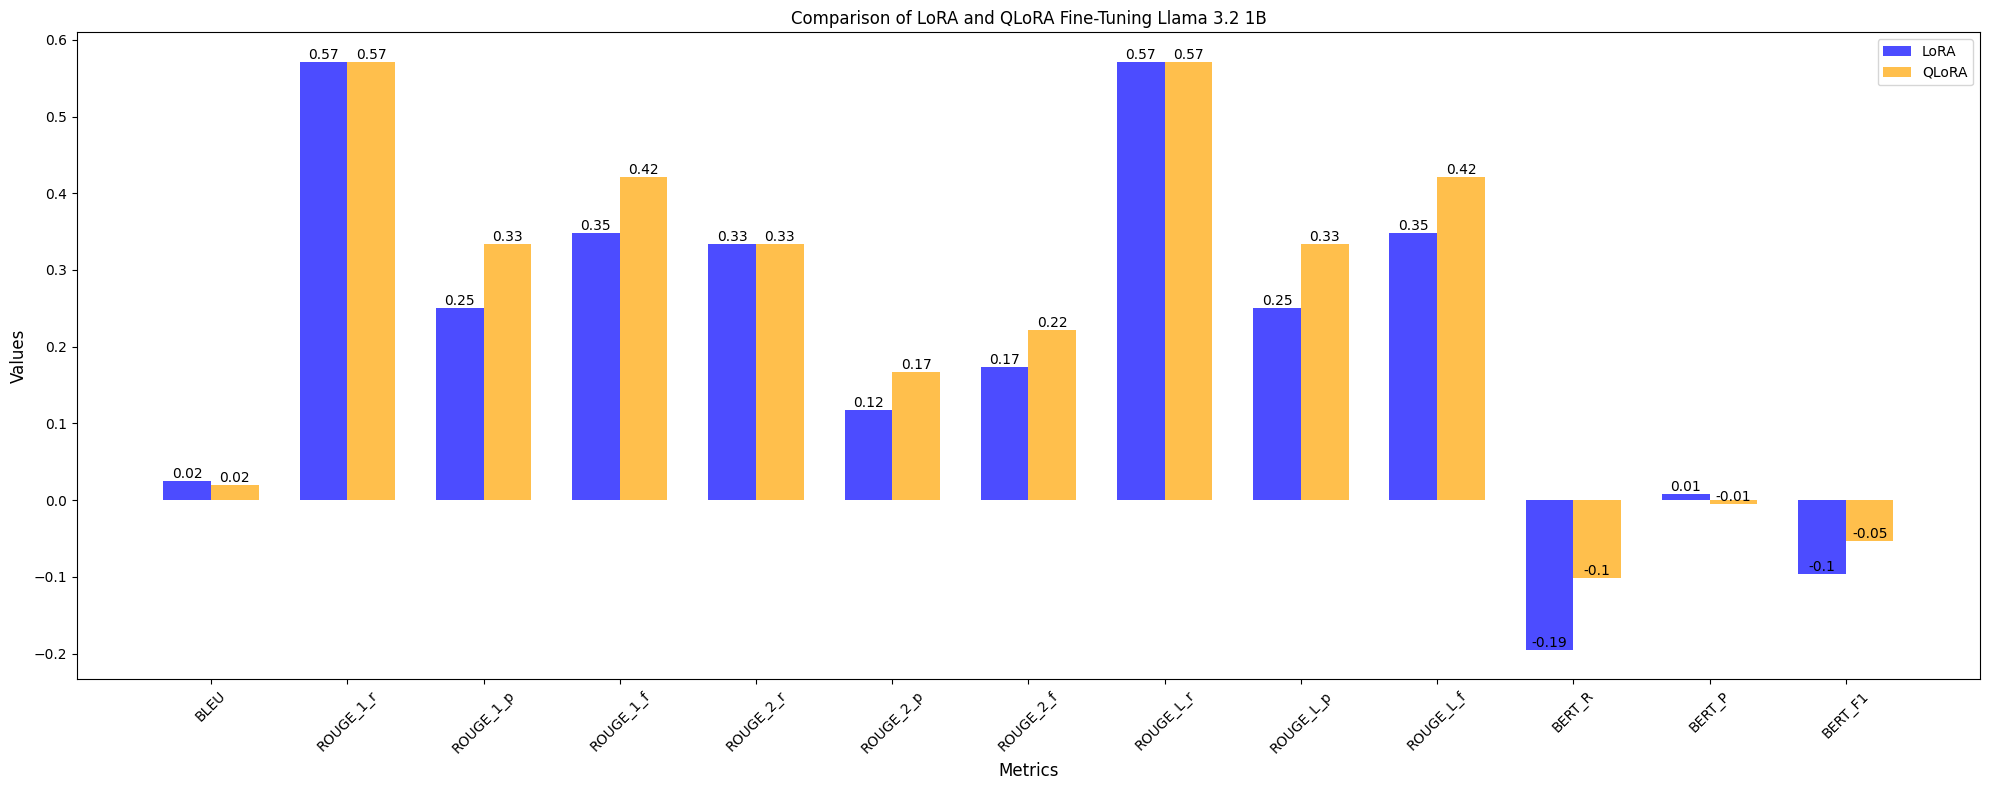

In [ ]:
#  Comparing the evaluation metrics of Llama 3.2 1B models fine-tuned with LoRA and QLoRA  
compare2CSV("/srv/data1/fuxiaoqin/Metrics_LM32_1B_QA_LoRA.csv", "/srv/data1/fuxiaoqin/Metrics_LM32_1B_QA_QLoRA.csv")

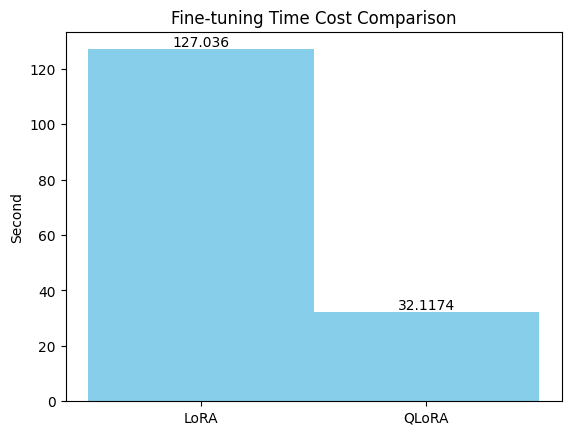

In [ ]:
#  Comparing time-costs of fine-tuing Llama 3.2 1B models with LoRA and QLoRA
import matplotlib.pyplot as plt

fig, ax  = plt.subplots()
ax.bar([1, 2], [lora_time, qlora_time], width=1,
       tick_label=['LoRA', 'QLoRA'], color='skyblue', align='center')
ax.bar_label(ax.containers[0])
plt.title('Fine-tuning Time Cost Comparison')
plt.ylabel('Second')
plt.show()